# Quantifying volume transports along pathways crossing a section in the VIKING20X model by Lagrangian particle tracking.

This fundamentally relies on the idea that we can associate a volume transport with a particle, and that this volume transport remains constant (or changes only slowly) as we follow the particle. So like a streamtube.

This assumption is possibly only strictly valid in the absence of mixing, and possibly only for the mean flow. Never mind though, we'll press on and consider the implications further down the line. 

First, consider how to sample the velocity field with particles to accurately estimate the transport across a section, and enable us to track the volume transport upstream and downstream. There are a couple of obvious options:

1. Randomly sample the section with particles at time t. Each particle, p, then has an associated volume transport, $V_p$:
$$ V_p = \frac{A}{N}\boldsymbol{u_p \cdot n_p}, $$
where $A$ is section area, $N$ the number of particles, and $\boldsymbol{u_p \cdot n_p}$ the velocity normal to the section at point $p$.

2. Sample with particles with local release density proportional to the local velocity normal to the section. Every particle is then associated with the same volume transport.

Method 1 is easier to set up so I'll look at that first. Method 2 might be more efficient (better results with fewer particles).

### Method 1

- Select a section (Greenland - Iceland - Shetland - Scotland)

- Calculate VIKING20X model volume transport across the section accurately

- Estimate volume transport based on N randomly released particles

## Technical preample

In [21]:
%matplotlib inline
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xorca_brokenline as bl
from xorca_lonlat2ij import get_ij
from matplotlib import colors as c
import matplotlib.dates as mdates
import seaborn as sns
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/

In [22]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})
years_fmt = mdates.DateFormatter('%Y-%m-%d')
sns.set_palette("colorblind")

In [23]:
from dask.distributed import Client

In [24]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=8e9)
client

/opt/tljh/user/envs/py3_euler_brokenline/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:46431 Dashboard: /user/workshop007/proxy/42325/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


_(Click on the link above if you want to see the Dask cluster in action.)_

## Parameters

Let's make it a habit to collect everyting we might want to change at a later point (the parameters of the analysis) in a central place.

In [25]:
# paramters

global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"
restrict_years = "201[4-7]"  # restricts to 2014 to 2017

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [26]:
U_files = (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}_{experiment_id}_1m_{restrict_years}????_{restrict_years}????_grid_U.nc")
U_files = list(sorted(U_files))
print(f"found {len(U_files)} grid-U files")

V_files = (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}_{experiment_id}_1m_{restrict_years}????_{restrict_years}????_grid_V.nc")
V_files = list(sorted(V_files))
print(f"found {len(V_files)} grid-V files")

mesh_hgr_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_hgr*.nc")
mesh_hgr_files = list(sorted(mesh_hgr_files))
print(f"found {len(mesh_hgr_files)} mesh_hgr files")

mesh_zgr_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_zgr*.nc")
mesh_zgr_files = list(sorted(mesh_zgr_files))
print(f"found {len(mesh_zgr_files)} mesh_zgr files")

mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mask*.nc")
mask_files = list(sorted(mask_files))
print(f"found {len(mask_files)} mask files")

mesh_mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")


found 4 grid-U files
found 4 grid-V files
found 1 mesh_hgr files
found 1 mesh_zgr files
found 1 mask files
found 1 mesh mask files


In [27]:
gridU = xr.open_mfdataset(
    U_files,
    chunks={
        "time_counter": 1, "depthu": 1,
        "y": None, "x": None
    },
    combine='by_coords'
)
gridV = xr.open_mfdataset(
    V_files,
    chunks={
        "time_counter": 1, "depthv": 1,
        "y": None, "x": None
    },
    combine='by_coords'
)
# gridU = xr.open_dataset(gridU_files[0])
# gridV = xr.open_dataset(gridV_files[0])
mesh_hgr = xr.open_dataset(mesh_hgr_files[0])
mesh_zgr = xr.open_dataset(mesh_zgr_files[0])
mask = xr.open_dataset(mask_files[0])
mesh_mask = xr.open_dataset(mesh_mask_files[0])

fmask = mask['fmask'].isel(t=0,z=0)


## Define a section and find grid points along the section

In [28]:
vertices_lat = np.array([68.74,65.8,64.78,65,62.2,60.33,58.99,58.58])
vertices_lon = np.array([-28.73,-23,-18.4,-14,-7.0,-1.3,-3.06,-3.21])
ll_points = np.vstack((vertices_lat, vertices_lon)).T
ll_points

array([[ 68.74, -28.73],
       [ 65.8 , -23.  ],
       [ 64.78, -18.4 ],
       [ 65.  , -14.  ],
       [ 62.2 ,  -7.  ],
       [ 60.33,  -1.3 ],
       [ 58.99,  -3.06],
       [ 58.58,  -3.21]])

## Find related indices

This takes an inordinate amount of time, because `get_ij` will transform grid points on the (spherical) earth to 3D, and do the nearest-neighbor-lookup there. There are faster ways. Probably more efficient for many points.

In [29]:
vertices_ji = get_ij(
    mesh_mask,
    ll_points,
    grid="f",
    xgcm=False,
    xarray_out=False
)

In [30]:
print(vertices_ji)

[[2476 1410]
 [2371 1494]
 [2338 1567]
 [2352 1636]
 [2271 1762]
 [2225 1870]
 [2174 1848]
 [2160 1848]]


In [65]:
ji_pairs = vertices_ji

ji = bl.section_indices(ji_pairs=ji_pairs)
jj,ii = zip(*ji)

def plot_selected_points():
    p = plt.figure(figsize=(10,8))
    fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
    plt.plot(ii,jj)

    plt.ylim(2000,2500)
    plt.xlim(1400,2000)

    plt.ylabel("j")
    plt.xlabel("i")
    plt.title('Selected points')
    return

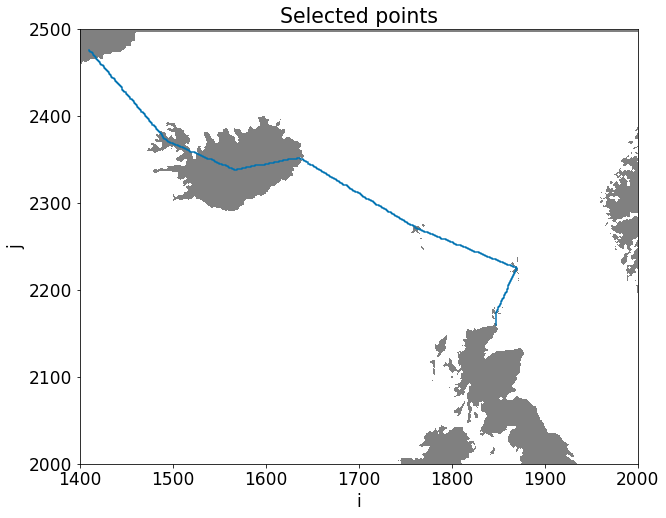

In [66]:
plot_selected_points()

In [69]:
ji_pairs = vertices_ji

ji = bl.section_indices(ji_pairs=ji_pairs)
jj,ii = zip(*ji)

def plot_selected_points():
    p = plt.figure(figsize=(10,8))
    fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
    plt.plot(ii,jj)

    plt.ylim(2185,2310)
    plt.xlim(1740,1900)

    plt.ylabel("j")
    plt.xlabel("i")
    plt.title('Selected points')
    return

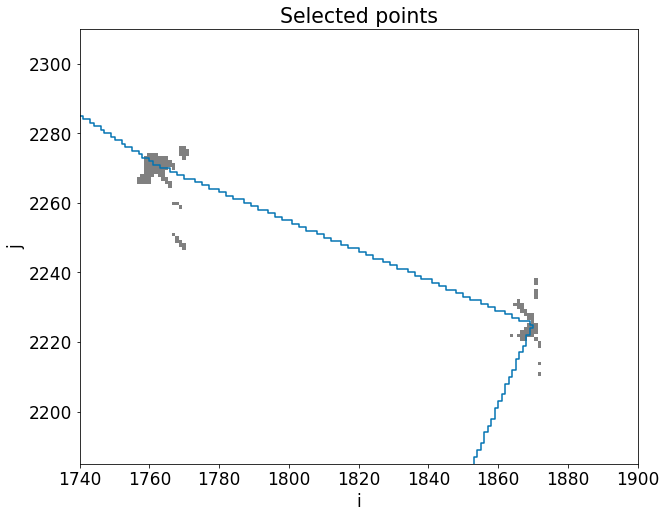

In [70]:
plot_selected_points()

## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.


In [32]:
ji = bl.section_indices(ji_pairs=ji_pairs)
gridU_processed, gridV_processed = bl.shift_grids(gridU=gridU, gridV=gridV)
section = bl.select_section(ji,gridU_processed,gridV_processed,mesh_hgr,mesh_zgr,mask).compute()
# reverse direction
section['u_normal']=-section['u_normal']

Section includes the velocity normal to the section (either U or V, depending on the orientation of each segment), the length and depth of each segment and a land-sea mask variable. 

In [33]:
section

<xarray.Dataset>
Dimensions:       (c: 826, time_counter: 48, z: 46)
Coordinates:
  * c             (c) float64 3.086e+03 5.9e+03 ... 2.559e+06 2.563e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 2014-01-16T12:00:00 ... 2017-12-16T12:00:00
Data variables:
    u_normal      (time_counter, z, c) float64 0.0 -0.0 0.0 -0.0 ... 0.0 0.0 0.0
    dx            (c) float64 3.086e+03 2.813e+03 ... 3.303e+03 3.304e+03
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Plot mean velocity normal to section.

### Northward, into the page, is positive.

### Greenland on the left, Scotland on the right.

Section is a zigzag line following grid cell boundaries, so normal to section is either u (on N-S boundaries) or v (on E-W boundaries). This is where the 'vertical' stripes on the plot come from, they are not structure in the velocity field.

In [71]:
def plot_section():    
    # whole section
    section['u_normal'].mean('time_counter').plot(cmap=co.cm.balance)
    section['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
    # slice parts of section slice(start,stop,step)
    # section.isel(c=slice(740,-1,1))['u_normal'].mean('time_counter').plot()
    # section.isel(c=slice(740,-1,1))['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
    plt.ylim(1500,0)
    plt.ylabel("Depth (m)")
    plt.xlabel("Distance (m)")
    plt.title("4-year, 2014-2017, mean velocity normal to section. Positive into page.")
    return

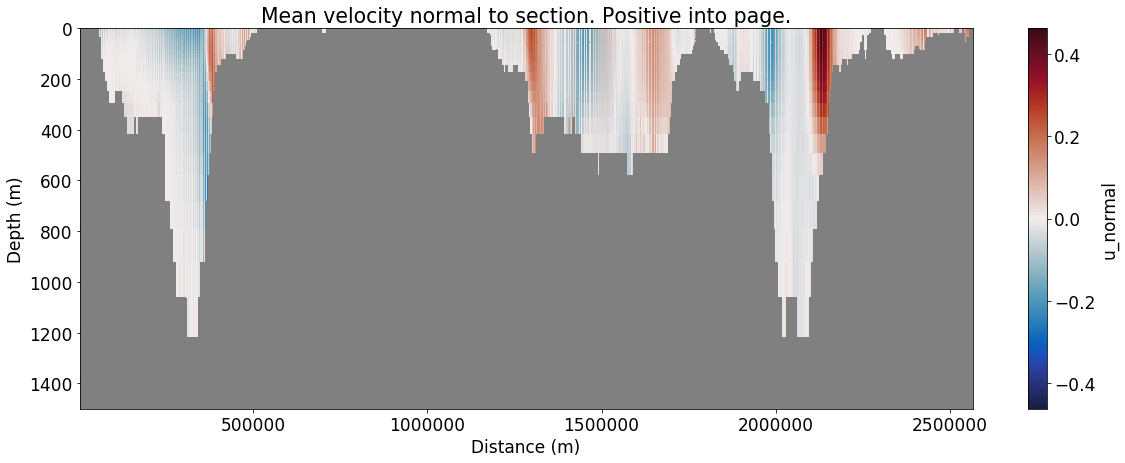

In [34]:
plot_section()

## Monthly mean volume transport

In [72]:
transport_all = bl.calculate_transport(section)
transport_GI  = bl.calculate_transport(section.isel(c=slice(200)))
transport_IFR = bl.calculate_transport(section.isel(c=slice(380,580,1)))
transport_FSC = bl.calculate_transport(section.isel(c=slice(580,740,1)))
transport_SS =  bl.calculate_transport(section.isel(c=slice(740,-1,1)))

In [36]:
plot_transport_timeseries();
    fig, ax = plt.subplots()
    transport_all.trsp.plot(color = 'k', label = 'Total')
    transport_GI.trsp.plot(label = 'Greenland-Iceland')
    transport_IFR.trsp.plot(label = 'Iceland-Faroe')
    transport_FSC.trsp.plot(label = 'Faroe-Shetland')
    transport_SS.trsp.plot(label = 'Shetland-Orkney-Scotland')
    plt.ylabel("Northward Volume transport (Sv)")
    plt.xlabel("Date")
    plt.grid()
    plt.legend();

    # format the ticks
    ax.xaxis.set_major_formatter(years_fmt)
    return

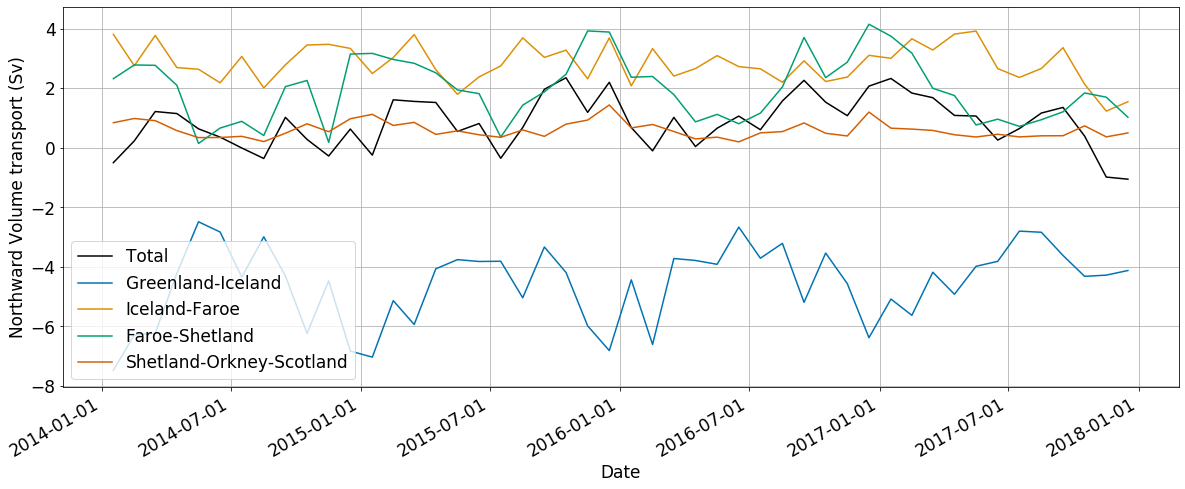

In [36]:
plot_transport_timeseries()

## Transport estimates from particle releases for 2016

- These are estimates on the sections at particle release time, to test how many particles might be needed for reliable volume transport estimates. 

- These use 4000 particles per sub-section.

- For Iceland-Faroe and Faroe-Shetland subsections.

In [37]:
## Parameters
# Project path
project_path = Path.cwd() / '..'
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# Parcels track data file
path_data_tracks = Path("parcels_experiments_202004/03.2_advanced_lagrangian_modelling") 
filename_FSC = "test_forward_FSC_2016"
filename_IFR = "test_forward_IFR_2016"

nParticles = 4000.0

# section area calculation on FSC (61N)

lat2metres_FSC = 60.0*1852.0
lon2metres_FSC = 60.0*1852.0*np.cos(np.radians(61.0))

sealandratio_FSC = 5591.0/20000.0 # 'wet' area scaling based on particle release experiments
sectionAreaEW_FSC = 5.7 * 1500.0 * sealandratio_FSC * lon2metres_FSC  
sectionAreaNS_FSC = 1.87 * 1500.0 * sealandratio_FSC * lat2metres_FSC

# section area calculation on IFR (63.5N)

lat2metres_IFR = 60.0*1852.0
lon2metres_IFR = 60.0*1852.0*np.cos(np.radians(63.5))

sealandratio_IFR = 9308.0/20000.0 # 'wet' area scaling based on particle release experiments
sectionAreaEW_IFR = 7.0 * 700.0 * sealandratio_IFR * lon2metres_IFR  
sectionAreaNS_IFR = 2.8 * 700.0 * sealandratio_IFR * lat2metres_IFR


### Read in the data

In [46]:
files_tracks_FSC = (project_path / path_data_tracks).glob(f"{filename_FSC}*.nc")
files_tracks_FSC = list(sorted(files_tracks_FSC))
files_tracks_IFR = (project_path / path_data_tracks).glob(f"{filename_IFR}*.nc")
files_tracks_IFR = list(sorted(files_tracks_IFR))


4000 particle estimate

In [47]:
transport_estimate_FSC = np.zeros(12)
# print(transports_FSC)
for i in range(12):
    trackfile_FSC = files_tracks_FSC[i]
    ds = xr.open_dataset(trackfile_FSC)
    transport_estimate_FSC[i] = ((sectionAreaEW_FSC*ds.isel(obs=0).vvel[:]*lat2metres_FSC +
                            sectionAreaNS_FSC*ds.isel(obs=0).uvel[:]*lon2metres_FSC)/nParticles).sum().data
# print(transport_estimate_FSC)

Faroe-Shetland Channel particle release (December 2016).

In [50]:
def plot_release_FSC():
    plt.figure(figsize = (12,5))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        20,
        ds.isel(obs=0).vvel.data.flatten()*lon2metres_FSC
         , vmin = -.2, vmax = .2
        ,cmap= co.cm.balance
    #    ,alpha=0.3
    )

    plt.ylim(1300,0)

    plt.colorbar(label = "vvel [m/s]")
    plt.show()
    return

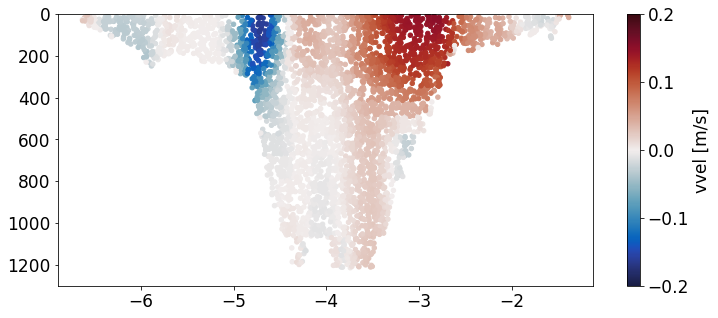

In [51]:
plot_release_FSC()

In [52]:
transport_estimate_IFR = np.zeros(12)
# print(transport_estimate_IFR)
for i in range(12):
    trackfile_IFR = files_tracks_IFR[i]
    ds = xr.open_dataset(trackfile_IFR)
    transport_estimate_IFR[i] = ((sectionAreaEW_IFR*ds.isel(obs=0).vvel*lat2metres_IFR +
                            sectionAreaNS_IFR*ds.isel(obs=0).uvel*lon2metres_IFR)/nParticles).sum().data
# print(transport_estimate_IFR)

Iceland-Faroe Ridge particle release (December 2016).

In [61]:
def plot_release_IFR():
    plt.figure(figsize = (12,5))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        20,
        ds.isel(obs=0).vvel.data.flatten()*lon2metres_IFR
         , vmin = -.2, vmax = .2
        ,cmap= co.cm.balance
    #    ,alpha=0.3
    )

    plt.ylim(1300,0)

    plt.colorbar(label = "vvel [m/s]")
    plt.show()
    return

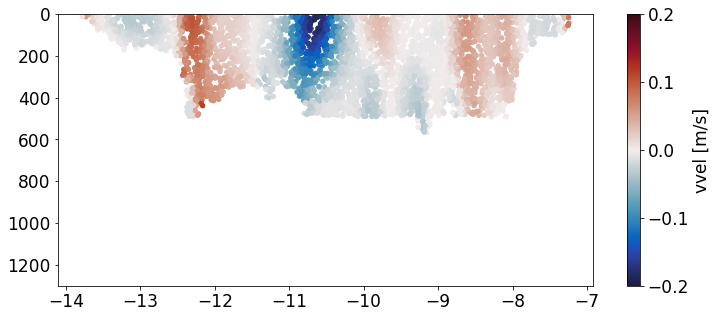

In [62]:
plot_release_IFR()

### Plot accurate transports from model calculations against estimates from random particle samples.

In [40]:
plot_transport_comparison():
    fig, ax = plt.subplots()
    # transport_all.trsp[24:36].plot(color = 'k', label = 'Total')
    # transport_GI.trsp[24:36].plot(label = 'Greenland-Iceland')
    transport_IFR.trsp[24:36].plot(label = 'Iceland-Faroe')
    transport_FSC.trsp[24:36].plot(label = 'Faroe-Shetland')
    # transport_SS.trsp[24:36].plot(label = 'Shetland-Orkney-Scotland')
    plt.ylabel("Northward Volume transport (Sv)")
    plt.xlabel("Date")
    plt.grid()

    plt.ylim(0,4.5)
    # format the ticks
    ax.xaxis.set_major_formatter(years_fmt)

    plt.scatter(transport_all.time_counter[24:36].data,transport_estimate_IFR/1000000.0,
                marker = 'x', s = 50, label = 'I-F estimate')
    plt.scatter(transport_all.time_counter[24:36].data,transport_estimate_FSC/1000000.0,
                marker = 'x', s = 50, label = 'F-S estimate')
    plt.legend()
    plt.title("Northward transport comparison. Full model calculation vs. particle-based estimate");
    return

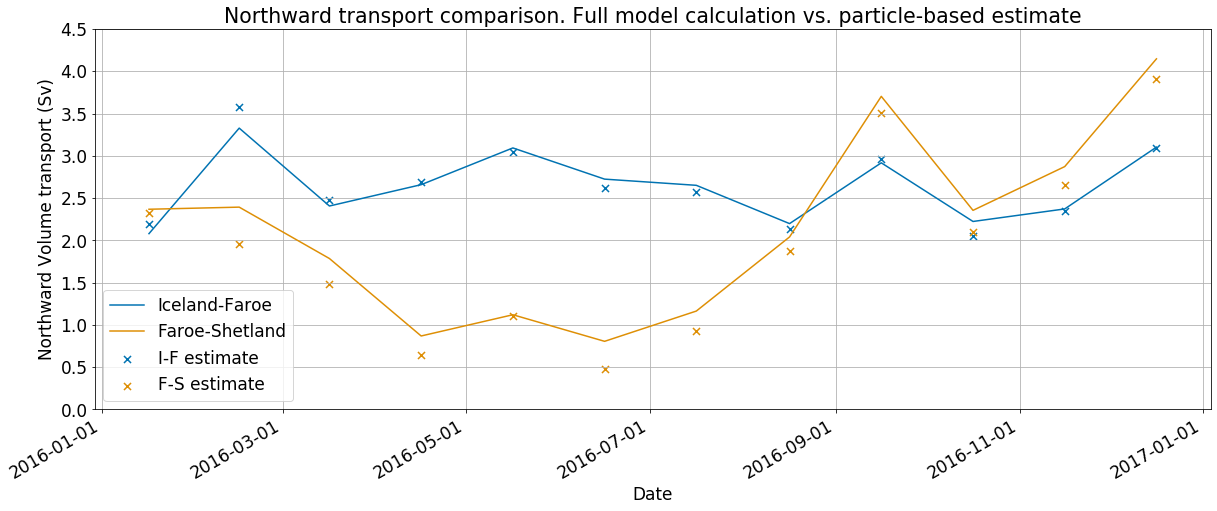

In [40]:
plot_transport_comparison()

### **Conclusion:** 

- Estimates are not bad with 4000 particles on each sub-section. Errors well below the monthly transport variability.

$$12500\, particles \times 12\, months \times 40\, years = 6000000\, particles$$

- There may be some systematic underestimate of total transport in Faroe-Shetland Channel.

- Random sample was taken from the same positions each time. This may explain the possible bias. Probably need to vary this (while keeping it reproducible).

- Probably under-sampling the strong narrow currents leads to the bias -- use more particles or release them more intelligently.


In [41]:
# %conda list